In [1]:
import xarray as xr
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio import features
from affine import Affine
import geopandas as gpd
import rioxarray
import paths
import numpy as np
import matplotlib.pyplot as plt

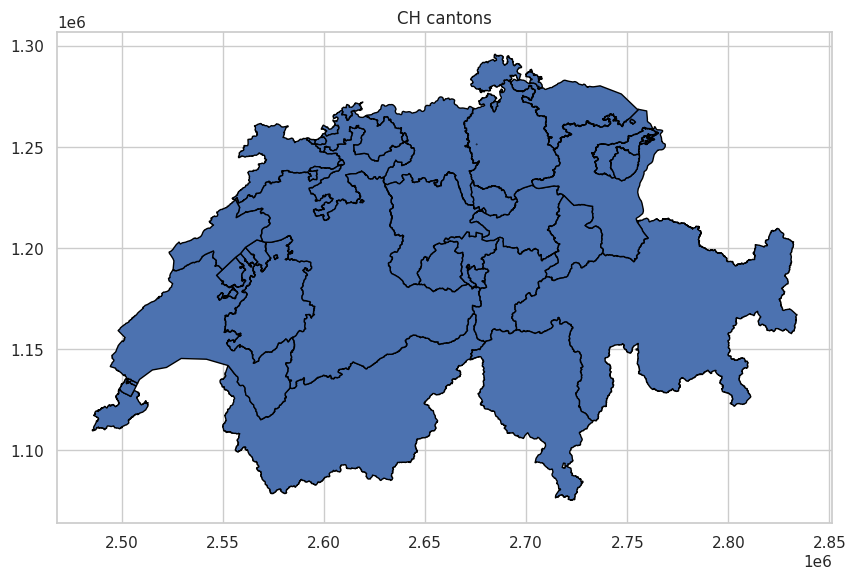

In [2]:
shp_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Processing_and_Analysis_Scripts/Cantons_zipfile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp"

gdf = gpd.read_file(shp_path)

gdf.plot(figsize=(10, 10), edgecolor='black')
plt.title("CH cantons")
plt.show()


Alpine	Graubünden	
Jura	Jura	
Central Plateau (Mittelland)	Bern	
Pre-Alpine / Foothills	Lucerne	
Southern / Mediterranean-influenced	Ticino

Some exploration. 


In [3]:
print(gdf.columns)

Index(['UUID', 'DATUM_AEND', 'DATUM_ERST', 'ERSTELL_J', 'ERSTELL_M',
       'GRUND_AEND', 'HERKUNFT', 'HERKUNFT_J', 'HERKUNFT_M', 'REVISION_J',
       'REVISION_M', 'REVISION_Q', 'OBJEKTART', 'KANTONSNUM', 'SEE_FLAECH',
       'KANTONSFLA', 'NAME', 'ICC', 'EINWOHNERZ', 'geometry'],
      dtype='object')


In [4]:
print(gdf["NAME"].unique())

['Genève' 'Thurgau' 'Valais' 'Aargau' 'Schwyz' 'Zürich' 'Obwalden'
 'Fribourg' 'Glarus' 'Uri' 'Nidwalden' 'Solothurn'
 'Appenzell Ausserrhoden' 'Jura' 'Graubünden' 'Vaud' 'Luzern' 'Ticino'
 'Zug' 'Basel-Landschaft' 'St. Gallen' 'Schaffhausen' 'Bern' 'Basel-Stadt'
 'Neuchâtel' 'Appenzell Innerrhoden']


In [5]:
shapefile= gpd.read_file("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Processing_and_Analysis_Scripts/Cantons_zipfile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp")
da = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Processing_and_Analysis_Scripts/data_1971_2023/HR_files_full/TabsD_1971_2023.nc")["TabsD"]

In [6]:
highlighted_cantons = {"Graubünden":"red", #Alpine
                       "Ticino":"blue", #mediterranean
                         "Luzern":"yellow",  #prealpin
                         "Aargau":"green", #mittelland
                         "Jura":"purple"} #plateau

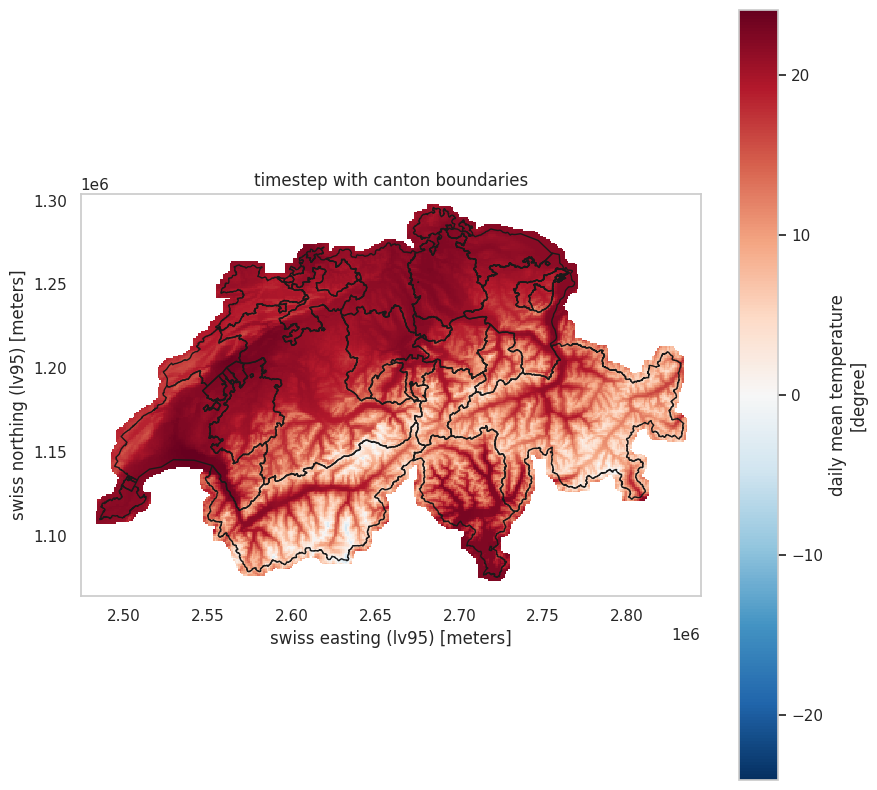

In [7]:
da_slice = da.isel(time=2000)

fig, ax = plt.subplots(figsize=(10, 10))
im = da_slice.plot(ax=ax)
shapefile.boundary.plot(ax=ax, color='k', linewidth=1)
plt.title("timestep with canton boundaries")
plt.show()

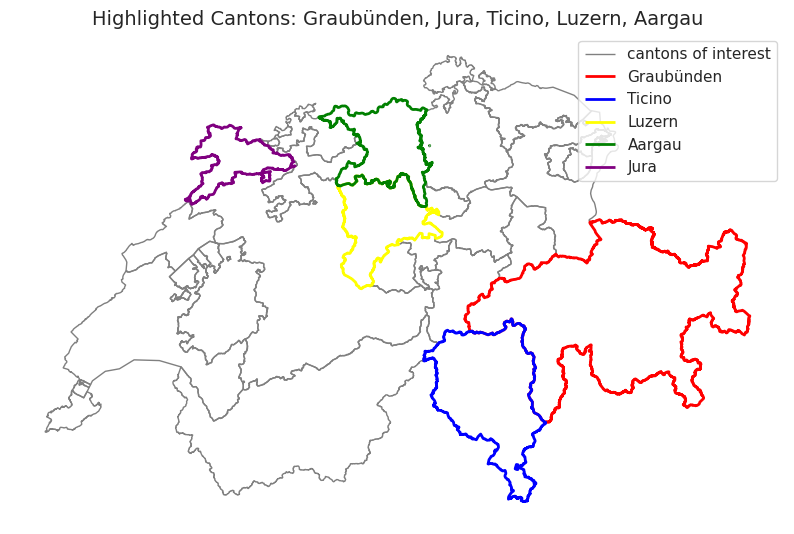

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, color='gray', linewidth=1, label='cantons of interest')

for canton,color in highlighted_cantons.items():
    gdf[gdf['NAME'] == canton].boundary.plot(ax=ax, color=color, linewidth=2, label=canton)

plt.title("Highlighted Cantons: Graubünden, Jura, Ticino, Luzern, Aargau", fontsize=14)
plt.legend()
plt.axis('off')
plt.show()

Cantonwise stats tbs as .nc files 

In [9]:
cantons= ["Graubünden"] #Alpine
time = da.time

canton_series = xr.DataArray(
    np.full((len(time), len(cantons)), np.nan),
    coords={"time": time, "canton": cantons},
    dims=["time", "canton"]
)

In [10]:
da_crs = da.rio.write_crs(gdf.crs)

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/pyproj/crs/_cf1x8.py:514: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


In [11]:
for i, canton in enumerate(cantons):
    shape = gdf[gdf["NAME"] == canton].geometry
    mask = da_crs.rio.clip(shape, gdf.crs, drop=False).notnull()

    #Mask creation
    masked = da_crs.where(mask)

    canton_series[:, i] = masked.mean(dim=("N", "E"), skipna=True)


canton_series.name = "TabsD_canton"
canton_series.to_netcdf(f"TabsD_canton_{canton}_timeseries.nc")

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/pyproj/crs/_cf1x8.py:514: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


In [12]:
#Obs
#Coarse files
# Bicubic files 
#Unet files
#LDM files

In [13]:
#ldm_precip=xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")["precip"].sel(time=slice("2011-01-01","2023-12-31"))

In [14]:
# After extracting the DataArray for each city/model:
def clean_and_slice(arr):
    # arr is an xarray.DataArray
    arr = arr.sel(time=slice("2011-01-01", "2023-12-31"))
    return arr.values[~np.isnan(arr.values)]

In [ ]:
from closest_grid_cell import select_nearest_grid_cell

locarno_lat, locarno_lon = 46.1709, 8.7995
bern_lat, bern_lon = 46.9480, 7.4474
zurich_lat, zurich_lon = 47.3769, 8.5417

# Open datasets as Dataset, not DataArray
obs_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step1_latlon.nc')
coarse_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step2_coarse.nc')
bicubic_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step3_interp.nc')
unet_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline_CRPS.nc")
#ldm_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")

# Extract precip time series for Locarno
obs_locarno = select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
coarse_locarno = select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
bicubic_locarno = select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
unet_locarno = select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values
#ldm_locarno = select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values

# Extract time series for Bern
obs_bern = select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
coarse_bern = select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
bicubic_bern = select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
unet_bern = select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="precip")['data'].values
#ldm_bern = select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'].values



#Extract zurich 
obs_zurich = select_nearest_grid_cell(obs_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values
coarse_zurich = select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values
bicubic_zurich = select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values
unet_zurich = select_nearest_grid_cell(unet_ds, zurich_lat, zurich_lon, var_name="precip")['data'].values


# Locarno
obs_locarno = clean_and_slice(select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
coarse_locarno = clean_and_slice(select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
bicubic_locarno = clean_and_slice(select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
unet_locarno = clean_and_slice(select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="precip")['data'])
#ldm_locarno = clean_and_slice(select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'])

# Bern
obs_bern = clean_and_slice(select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
coarse_bern = clean_and_slice(select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
bicubic_bern = clean_and_slice(select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
unet_bern = clean_and_slice(select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="precip")['data'])
#ldm_bern = clean_and_slice(select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'])


#Zurich
obs_zurich = clean_and_slice(select_nearest_grid_cell(obs_ds, zurich_lat    , zurich_lon, var_name="RhiresD")['data'])
coarse_zurich = clean_and_slice(select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'])
bicubic_zurich = clean_and_slice(select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'])
unet_zurich = clean_and_slice(select_nearest_grid_cell(unet_ds, zurich_lat, zurich_lon, var_name="precip")['data'])


# Get common quantiles for Locarno
quantiles_locarno = np.linspace(0, 1, min(len(obs_locarno), len(coarse_locarno), len(bicubic_locarno)))
obs_q_locarno = np.quantile(obs_locarno, quantiles_locarno)
coarse_q_locarno = np.quantile(coarse_locarno, quantiles_locarno)
bicubic_q_locarno = np.quantile(bicubic_locarno, quantiles_locarno)
unet_q_locarno = np.quantile(unet_locarno, quantiles_locarno)
#ldm_q_locarno = np.quantile(ldm_locarno, quantiles_locarno)

# Get common quantiles 
quantiles_bern = np.linspace(0, 1, min(len(obs_bern), len(coarse_bern), len(bicubic_bern)))
obs_q_bern = np.quantile(obs_bern, quantiles_bern)
coarse_q_bern = np.quantile(coarse_bern, quantiles_bern)
bicubic_q_bern = np.quantile(bicubic_bern, quantiles_bern)
unet_q_bern = np.quantile(unet_bern, quantiles_bern)
#ldm_q_bern = np.quantile(ldm_bern, quantiles_bern)


#Common quantiles 
quantiles_zurich = np.linspace(0, 1, min(len(obs_zurich), len(coarse_zurich), len(bicubic_zurich)))
obs_q_zurich = np.quantile(obs_zurich, quantiles_zurich)
coarse_q_zurich = np.quantile(coarse_zurich, quantiles_zurich)
bicubic_q_zurich = np.quantile(bicubic_zurich, quantiles_zurich)
unet_q_zurich = np.quantile(unet_zurich, quantiles_zurich)

# QQ for Locarno
plt.figure(figsize=(8, 8))


quantiles = np.linspace(0, 1, 101)

obs_q_locarno = np.quantile(obs_locarno, quantiles)
coarse_q_locarno = np.quantile(coarse_locarno, quantiles)
bicubic_q_locarno = np.quantile(bicubic_locarno, quantiles)
unet_q_locarno = np.quantile(unet_locarno, quantiles)

plt.figure(figsize=(8, 5))
plt.plot(quantiles, coarse_q_locarno - obs_q_locarno, label='Coarse - Obs', color='orange')
plt.plot(quantiles, bicubic_q_locarno - obs_q_locarno, label='Bicubic - Obs', color='blue')
plt.plot(quantiles, unet_q_locarno - obs_q_locarno, label='UNet - Obs', color='green')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Quantile')
plt.ylabel('Bias (Model - Obs)')
plt.title('Quantile Bias: Locarno (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()



# Bern
obs_q_bern = np.quantile(obs_bern, quantiles)
coarse_q_bern = np.quantile(coarse_bern, quantiles)
bicubic_q_bern = np.quantile(bicubic_bern, quantiles)
unet_q_bern = np.quantile(unet_bern, quantiles)

plt.figure(figsize=(8, 5))
plt.plot(quantiles, coarse_q_bern - obs_q_bern, label='Coarse - Obs', color='orange')
plt.plot(quantiles, bicubic_q_bern - obs_q_bern, label='Bicubic - Obs', color='blue')
plt.plot(quantiles, unet_q_bern - obs_q_bern, label='UNet - Obs', color='green')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Quantile')
plt.ylabel('Bias (Model - Obs)')
plt.title('Quantile Bias: Bern (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

# Zurich
obs_q_zurich = np.quantile(obs_zurich, quantiles)
coarse_q_zurich = np.quantile(coarse_zurich, quantiles)
bicubic_q_zurich = np.quantile(bicubic_zurich, quantiles)
unet_q_zurich = np.quantile(unet_zurich, quantiles)

plt.figure(figsize=(8, 5))
plt.plot(quantiles, coarse_q_zurich - obs_q_zurich, label='Coarse - Obs', color='orange')
plt.plot(quantiles, bicubic_q_zurich - obs_q_zurich, label='Bicubic - Obs', color='blue')
plt.plot(quantiles, unet_q_zurich - obs_q_zurich, label='UNet - Obs', color='green')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Quantile')
plt.ylabel('Bias (Model - Obs)')
plt.title(" Quantile Bias: Zurich (2011-2023)")
plt.legend()
plt.grid(True)
plt.show()

Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 270.14
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 260.57
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 261.56
Variable 'precip' extracted
Time series shape: (4748,)
Data range: 0.35 to 182.61
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 74.20
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 77.33
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 78.10
Variable 'precip' extracted
Time series shape: (4748,)
Data range: 0.35 to 45.73
Variable 'RhiresD' extracted
Time series shape: (19358,)


Temperature QQ plot

Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -7.54 to 30.31
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -13.87 to 26.11
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -13.54 to 26.32
Variable 'temp' extracted
Time series shape: (4748,)
Data range: -7.18 to 29.63
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -17.65 to 27.63
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -17.97 to 27.46
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -18.21 to 27.37
Variable 'temp' extracted
Time series shape: (4748,)
Data range: -14.30 to 27.71
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -17.89 to 28.21
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -18.90 to 27.82
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -18.81 to 27.79
Variable 'temp' extracted
Time series shape: (4748,)
Data range: -12.46 to 28.06
Variable 'Ta

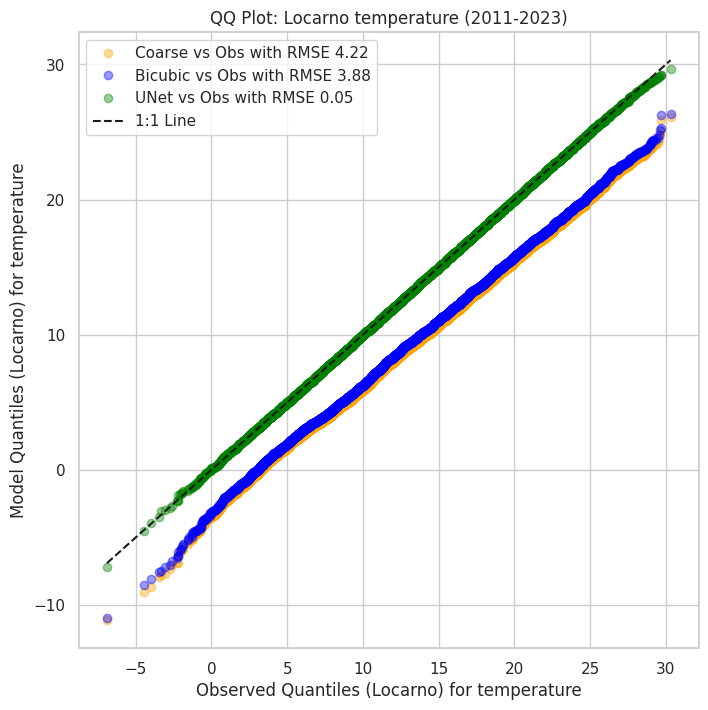

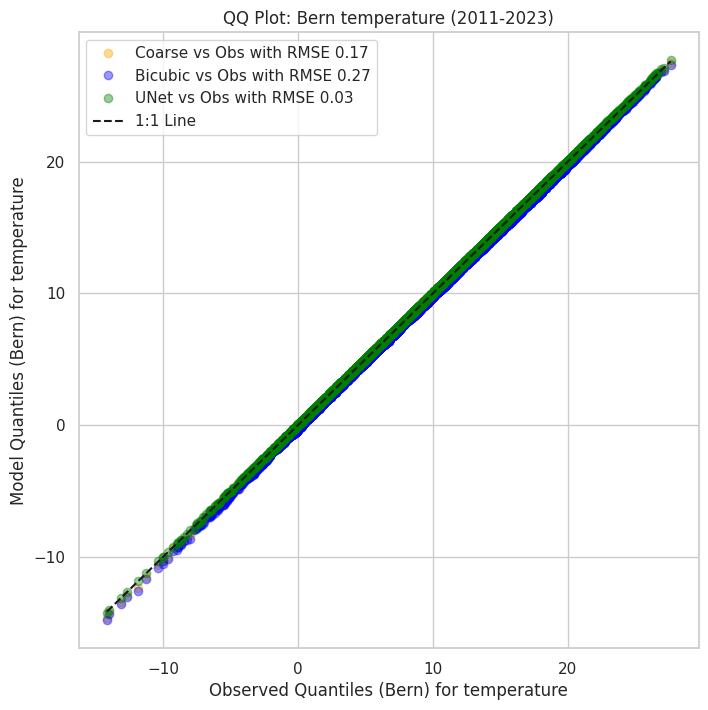

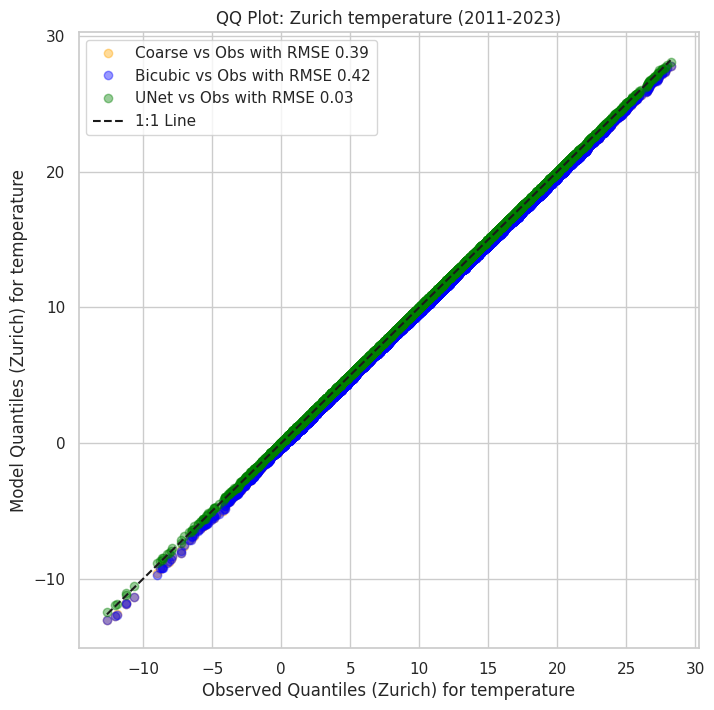

In [ ]:
from closest_grid_cell import select_nearest_grid_cell

# City coordinates
locarno_lat, locarno_lon = 46.1709, 8.7995
bern_lat, bern_lon = 46.9480, 7.4474
zurich_lat, zurich_lon = 47.3769, 8.5417


obs_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step1_latlon.nc')
coarse_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step2_coarse.nc')
bicubic_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step3_interp.nc')
unet_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline_CRPS.nc")
#ldm_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")

# Extract precip time series for Locarno
obs_locarno = select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
coarse_locarno = select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
bicubic_locarno = select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
unet_locarno = select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="temp")['data'].values
#ldm_locarno = select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values

# Extract time series for Bern
obs_bern = select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="TabsD")['data'].values
coarse_bern = select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="TabsD")['data'].values
bicubic_bern = select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="TabsD")['data'].values
unet_bern = select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="temp")['data'].values
#ldm_bern = select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'].values



#Extract zurich 
obs_zurich = select_nearest_grid_cell(obs_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'].values
coarse_zurich = select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'].values
bicubic_zurich = select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'].values
unet_zurich = select_nearest_grid_cell(unet_ds, zurich_lat, zurich_lon, var_name="temp")['data'].values


# Locarno
obs_locarno = clean_and_slice(select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'])
coarse_locarno = clean_and_slice(select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'])
bicubic_locarno = clean_and_slice(select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'])
unet_locarno = clean_and_slice(select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="temp")['data'])
#ldm_locarno = clean_and_slice(select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'])

# Bern
obs_bern = clean_and_slice(select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="TabsD")['data'])
coarse_bern = clean_and_slice(select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="TabsD")['data'])
bicubic_bern = clean_and_slice(select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="TabsD")['data'])
unet_bern = clean_and_slice(select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="temp")['data'])
#ldm_bern = clean_and_slice(select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'])


#Zurich
obs_zurich = clean_and_slice(select_nearest_grid_cell(obs_ds, zurich_lat    , zurich_lon, var_name="TabsD")['data'])
coarse_zurich = clean_and_slice(select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'])
bicubic_zurich = clean_and_slice(select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'])
unet_zurich = clean_and_slice(select_nearest_grid_cell(unet_ds, zurich_lat, zurich_lon, var_name="temp")['data'])

# Get common quantiles for Locarno
quantiles_locarno = np.linspace(0, 1, min(len(obs_locarno), len(coarse_locarno), len(bicubic_locarno)))
obs_q_locarno = np.quantile(obs_locarno, quantiles_locarno)
coarse_q_locarno = np.quantile(coarse_locarno, quantiles_locarno)
bicubic_q_locarno = np.quantile(bicubic_locarno, quantiles_locarno)
unet_q_locarno = np.quantile(unet_locarno, quantiles_locarno)
#ldm_q_locarno = np.quantile(ldm_locarno, quantiles_locarno)

# Get common quantiles for Bern
quantiles_bern = np.linspace(0, 1, min(len(obs_bern), len(coarse_bern), len(bicubic_bern)))
obs_q_bern = np.quantile(obs_bern, quantiles_bern)
coarse_q_bern = np.quantile(coarse_bern, quantiles_bern)
bicubic_q_bern = np.quantile(bicubic_bern, quantiles_bern)
unet_q_bern = np.quantile(unet_bern, quantiles_bern)
#ldm_q_bern = np.quantile(ldm_bern, quantiles_bern)


#Common quantiles for Zurich
quantiles_zurich = np.linspace(0, 1, min(len(obs_zurich), len(coarse_zurich), len(bicubic_zurich)))
obs_q_zurich = np.quantile(obs_zurich, quantiles_zurich)
coarse_q_zurich = np.quantile(coarse_zurich, quantiles_zurich)
bicubic_q_zurich = np.quantile(bicubic_zurich, quantiles_zurich)
unet_q_zurich = np.quantile(unet_zurich, quantiles_zurich)

# Plot QQ for Locarno
plt.figure(figsize=(8, 8))
#RMSE
rmse_coarse_locarno = np.sqrt(np.mean((coarse_q_locarno - obs_q_locarno) ** 2))
rmse_bicubic_locarno = np.sqrt(np.mean((bicubic_q_locarno - obs_q_locarno) ** 2))
rmse_unet_locarno = np.sqrt(np.mean((unet_q_locarno - obs_q_locarno) ** 2))
plt.plot(obs_q_locarno, coarse_q_locarno, 'o', label='Coarse vs Obs with RMSE {:.2f}'.format(rmse_coarse_locarno), alpha=0.4,color='orange')
plt.plot(obs_q_locarno, bicubic_q_locarno, 'o', label='Bicubic vs Obs with RMSE {:.2f}'.format(rmse_bicubic_locarno), alpha=0.4,color='blue')
plt.plot(obs_q_locarno, unet_q_locarno, 'o', label='UNet vs Obs with RMSE {:.2f}'.format(rmse_unet_locarno),color='green', alpha=0.4)
#plt.plot(obs_q_locarno, ldm_q_locarno, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_locarno.min(), obs_q_locarno.max()], [obs_q_locarno.min(), obs_q_locarno.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Locarno) for temperature')
plt.ylabel('Model Quantiles (Locarno) for temperature')
plt.title('QQ Plot: Locarno temperature (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()


# Plot QQ for Bern
plt.figure(figsize=(8, 8))
rmse_coarse_bern = np.sqrt(np.mean((coarse_q_bern - obs_q_bern) ** 2))
rmse_bicubic_bern = np.sqrt(np.mean((bicubic_q_bern - obs_q_bern) ** 2))
rmse_unet_bern = np.sqrt(np.mean((unet_q_bern - obs_q_bern) ** 2))
plt.plot(obs_q_bern, coarse_q_bern, 'o', label='Coarse vs Obs with RMSE {:.2f}'.format(rmse_coarse_bern), alpha=0.4,color='orange')
plt.plot(obs_q_bern, bicubic_q_bern, 'o', label='Bicubic vs Obs with RMSE {:.2f}'.format(rmse_bicubic_bern), alpha=0.4,color='blue')
plt.plot(obs_q_bern, unet_q_bern, 'o', label='UNet vs Obs with RMSE {:.2f}'.format(rmse_unet_bern),color='green', alpha=0.4)
#plt.plot(obs_q_bern, ldm_q_bern, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_bern.min(), obs_q_bern.max()], [obs_q_bern.min(), obs_q_bern.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Bern) for temperature')
plt.ylabel('Model Quantiles (Bern) for temperature')
plt.title('QQ Plot: Bern temperature (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()



# Plot QQ for Zurich
plt.figure(figsize=(8, 8))
rmse_coarse_zurich = np.sqrt(np.mean((coarse_q_zurich - obs_q_zurich) ** 2))
rmse_bicubic_zurich = np.sqrt(np.mean((bicubic_q_zurich - obs_q_zurich) ** 2))
rmse_unet_zurich = np.sqrt(np.mean((unet_q_zurich - obs_q_zurich) ** 2))
plt.plot(obs_q_zurich, coarse_q_zurich, 'o', label='Coarse vs Obs with RMSE {:.2f}'.format(rmse_coarse_zurich), alpha=0.4,color='orange')
plt.plot(obs_q_zurich, bicubic_q_zurich, 'o', label='Bicubic vs Obs with RMSE {:.2f}'.format(rmse_bicubic_zurich), alpha=0.4,color='blue')
plt.plot(obs_q_zurich, unet_q_zurich, 'o', label='UNet vs Obs with RMSE {:.2f}'.format(rmse_unet_zurich),color='green', alpha=0.4)
plt.plot([obs_q_zurich.min(), obs_q_zurich.max()], [obs_q_zurich.min(), obs_q_zurich.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Zurich) for temperature')
plt.ylabel('Model Quantiles (Zurich) for temperature')
plt.title('QQ Plot: Zurich temperature (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

SR metrics 

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

In [ ]:
def compute_metrics(obs, pred):
    psnr_list, ssim_list = [], []
    for t in range(obs.shape[0]):
        hr_img = obs.isel(time=t).values
        pred_img = pred.isel(time=t).values
        mask = ~np.isnan(hr_img) & ~np.isnan(pred_img)
        if not np.any(mask):
            psnr_list.append(np.nan)
            ssim_list.append(np.nan)
            continue
        hr_img = hr_img[mask]
        pred_img = pred_img[mask]
        if hr_img.max() == hr_img.min():


            psnr_list.append(np.nan)
            ssim_list.append(np.nan)
            continue
        psnr = peak_signal_noise_ratio(hr_img, pred_img, data_range=hr_img.max() - hr_img.min())
        try:
            ssim = structural_similarity(hr_img, pred_img, data_range=hr_img.max() - hr_img.min())
        except:
            ssim = np.nan
        psnr_list.append(psnr)
        ssim_list.append(ssim)
    return np.nanmean(psnr_list), np.nanmean(ssim_list)

In [ ]:
import pandas as pd

In [ ]:
obs_temp= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step1_latlon.nc')["TabsD"].sel(time=slice("2011-01-01","2023-12-31"))
coarse_temp= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step2_coarse.nc')["TabsD"].sel(time=slice("2011-01-01","2023-12-31"))
bicubic_temp= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step3_interp.nc')["TabsD"].sel(time=slice("2011-01-01","2023-12-31"))
unet_temp= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline_CRPS.nc")["temp"].sel(time=slice("2011-01-01","2023-12-31"))

In [ ]:
# temp
temp_metrics = {}
temp_metrics['Bicubic'] = compute_metrics(obs_temp, bicubic_temp)
temp_metrics['UNet'] = compute_metrics(obs_temp, unet_temp)
temp_df = pd.DataFrame(temp_metrics, index=['PSNR', 'SSIM']).T
print("temp metrics:")
print(temp_df)

temp metrics:
              PSNR      SSIM
Bicubic  23.020081  0.521482
UNet     46.113108  0.988201


In [ ]:
obs_precip = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step1_latlon.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))
bicubic_precip = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step3_interp.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))
unet_precip = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline_CRPS.nc")["precip"].sel(time=slice("2011-01-01","2023-12-31"))
coarse_precip = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step2_coarse.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))

In [ ]:
print(obs_precip.dims)
print(bicubic_precip.dims)
print(unet_precip.dims)

('time', 'N', 'E')
('time', 'N', 'E')
('time', 'N', 'E')


In [ ]:
print(obs_precip.coords)
print(bicubic_precip.coords)
print(unet_precip.coords)

Coordinates:
  * time     (time) datetime64[ns] 38kB 2011-01-01 2011-01-02 ... 2023-12-31
    lon      (N, E) float32 355kB ...
    lat      (N, E) float32 355kB ...
  * E        (E) float64 3kB 2.474e+06 2.476e+06 ... 2.842e+06 2.844e+06
  * N        (N) float64 2kB 1.064e+06 1.066e+06 ... 1.302e+06 1.304e+06
Coordinates:
  * time     (time) datetime64[ns] 38kB 2011-01-01 2011-01-02 ... 2023-12-31
    lon      (N, E) float32 355kB ...
    lat      (N, E) float32 355kB ...
  * E        (E) float64 3kB 2.474e+06 2.476e+06 ... 2.842e+06 2.844e+06
  * N        (N) float64 2kB 1.064e+06 1.066e+06 ... 1.302e+06 1.304e+06
Coordinates:
  * time     (time) datetime64[ns] 38kB 2011-01-01 2011-01-02 ... 2023-12-31
  * N        (N) int64 2kB 0 1 2 3 4 5 6 7 8 ... 232 233 234 235 236 237 238 239
  * E        (E) int64 3kB 0 1 2 3 4 5 6 7 8 ... 362 363 364 365 366 367 368 369
    lat      (N, E) float32 355kB ...
    lon      (N, E) float32 355kB ...


In [ ]:
unet_precip = unet_precip.assign_coords(N=obs_precip.N, E=obs_precip.E)

def mask_like(obs, pred):
    pred_masked = pred.where(~np.isnan(obs))
    return pred_masked

bicubic_precip_masked = mask_like(obs_precip, bicubic_precip)
unet_precip_masked = mask_like(obs_precip, unet_precip)

In [ ]:
# 1. Find time indices where all values are NaN or zero in obs_precip
empty_mask = (obs_precip.isnull() | (obs_precip == 0)).all(dim=["N", "E"])
empty_dates = obs_precip.time[empty_mask].values

# 2. Remove these dates from all time series
def remove_empty_dates(da, dates_to_remove):
    return da.sel(time=~np.isin(da.time, dates_to_remove))

obs_precip_clean = remove_empty_dates(obs_precip, empty_dates)
bicubic_precip_clean = remove_empty_dates(bicubic_precip, empty_dates)
unet_precip_clean = remove_empty_dates(unet_precip, empty_dates)
coarse_precip_clean = remove_empty_dates(coarse_precip, empty_dates)

In [ ]:

bicubic_precip_masked.to_netcdf("bicubic_precip_masked.nc")
unet_precip_masked.to_netcdf("unet_precip_masked.nc")

In [ ]:
# pr
precip_metrics = {}
precip_metrics['Bicubic'] = compute_metrics(obs_precip_clean, bicubic_precip_clean)
precip_metrics['UNet'] = compute_metrics(obs_precip_clean, unet_precip_clean)
precip_df = pd.DataFrame(precip_metrics, index=['PSNR', 'SSIM']).T
print("precip metrics:")
print(precip_df)

precip metrics:
              PSNR      SSIM
Bicubic  32.612588  0.918974
UNet     26.958072  0.529362


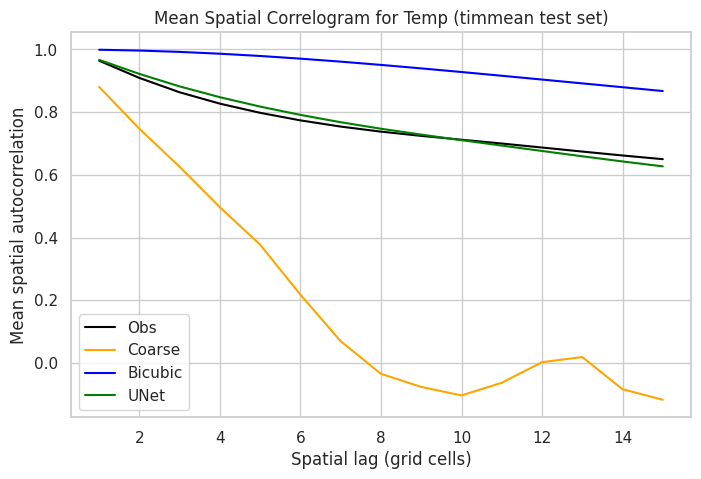

In [ ]:
def spatial_correlogram(field, max_lag=10):
    field = field - np.nanmean(field)
    corrs = []
    for lag in range(1, max_lag + 1):
        shifted_x = np.roll(field, lag, axis=1)
        shifted_y = np.roll(field, lag, axis=0)
        shifted_x[:, :lag] = np.nan
        shifted_y[:lag, :] = np.nan
        valid_x = ~np.isnan(field) & ~np.isnan(shifted_x)
        valid_y = ~np.isnan(field) & ~np.isnan(shifted_y)
        corr_x = np.corrcoef(field[valid_x], shifted_x[valid_x])[0,1] if np.any(valid_x) else np.nan
        corr_y = np.corrcoef(field[valid_y], shifted_y[valid_y])[0,1] if np.any(valid_y) else np.nan
        corrs.append(np.nanmean([corr_x, corr_y]))
    return np.array(corrs)

max_lag = 15
n_time = obs_temp.shape[0]

corrs_obs = []
corrs_coarse = []
corrs_bicubic = []
corrs_unet = []

for t in range(n_time):
    corrs_obs.append(spatial_correlogram(obs_temp.isel(time=t).values, max_lag=max_lag))
    corrs_coarse.append(spatial_correlogram(coarse_temp.isel(time=t).values, max_lag=max_lag))
    corrs_bicubic.append(spatial_correlogram(bicubic_temp.isel(time=t).values, max_lag=max_lag))
    corrs_unet.append(spatial_correlogram(unet_temp.isel(time=t).values, max_lag=max_lag))


corrs_obs = np.nanmean(corrs_obs, axis=0)
corrs_coarse = np.nanmean(corrs_coarse, axis=0)
corrs_bicubic = np.nanmean(corrs_bicubic, axis=0)
corrs_unet = np.nanmean(corrs_unet, axis=0)

lags = np.arange(1, max_lag+1)
plt.figure(figsize=(8,5))
plt.plot(lags, corrs_obs, label='Obs', color='black')
plt.plot(lags, corrs_coarse, label='Coarse', color='orange')
plt.plot(lags, corrs_bicubic, label='Bicubic', color='blue')
plt.plot(lags, corrs_unet, label='UNet', color='green')
plt.xlabel('Spatial lag (grid cells)')
plt.ylabel('Mean spatial autocorrelation')
plt.title('Mean Spatial Correlogram for Temp (timmean test set)')
plt.legend()
plt.grid(True)
plt.show()

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_3598973/4262367750.py:13: RuntimeWarning: Mean of empty slice
  corrs.append(np.nanmean([corr_x, corr_y]))


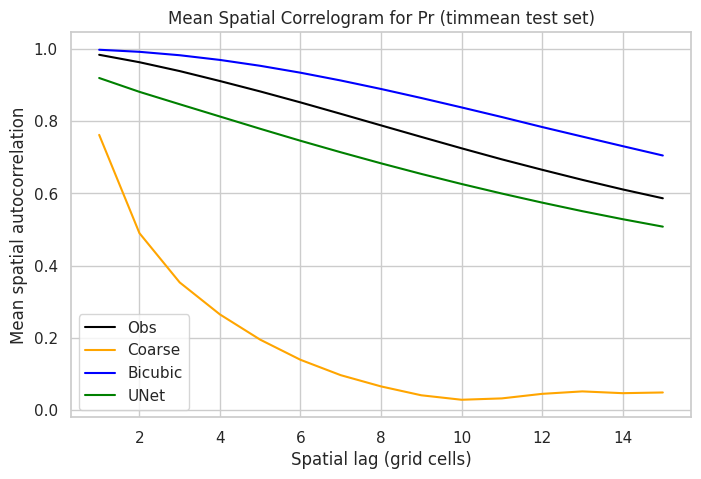

In [ ]:
def spatial_correlogram(field, max_lag=10):
    field = field - np.nanmean(field)
    corrs = []
    for lag in range(1, max_lag+1):
        shifted_x = np.roll(field, lag, axis=1)
        shifted_y = np.roll(field, lag, axis=0)
        shifted_x[:, :lag] = np.nan
        shifted_y[:lag, :] = np.nan
        valid_x = ~np.isnan(field) & ~np.isnan(shifted_x)
        valid_y = ~np.isnan(field) & ~np.isnan(shifted_y)
        corr_x = np.corrcoef(field[valid_x], shifted_x[valid_x])[0,1] if np.any(valid_x) else np.nan
        corr_y = np.corrcoef(field[valid_y], shifted_y[valid_y])[0,1] if np.any(valid_y) else np.nan
        corrs.append(np.nanmean([corr_x, corr_y]))
    return np.array(corrs)

max_lag = 15
n_time = obs_temp.shape[0]

corrs_obs = []
corrs_coarse = []
corrs_bicubic = []
corrs_unet = []

for t in range(n_time):
    corrs_obs.append(spatial_correlogram(obs_precip.isel(time=t).values, max_lag=max_lag))
    corrs_coarse.append(spatial_correlogram(coarse_precip.isel(time=t).values, max_lag=max_lag))
    corrs_bicubic.append(spatial_correlogram(bicubic_precip.isel(time=t).values, max_lag=max_lag))
    corrs_unet.append(spatial_correlogram(unet_precip.isel(time=t).values, max_lag=max_lag))

corrs_obs = np.nanmean(corrs_obs, axis=0)
corrs_coarse = np.nanmean(corrs_coarse, axis=0)
corrs_bicubic = np.nanmean(corrs_bicubic, axis=0)
corrs_unet = np.nanmean(corrs_unet, axis=0)

lags = np.arange(1, max_lag+1)
plt.figure(figsize=(8,5))
plt.plot(lags, corrs_obs, label='Obs', color='black')
plt.plot(lags, corrs_coarse, label='Coarse', color='orange')
plt.plot(lags, corrs_bicubic, label='Bicubic', color='blue')
plt.plot(lags, corrs_unet, label='UNet', color='green')
plt.xlabel('Spatial lag (grid cells)')
plt.ylabel('Mean spatial autocorrelation')
plt.title('Mean Spatial Correlogram for Pr (timmean test set)')
plt.legend()
plt.grid(True)
plt.show()